In [62]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import cv2
import torch
import pytesseract
%matplotlib inline

In [23]:
base_img_paths = [f"../dataset/labelled-captcha/level_{i+1}" for i in range(5)]
label_paths = [f"../dataset/labelled-captcha/labels_level_{i+1}.csv" for i in range(5)]

In [38]:
# Load labels, label matches corresponding image file
df = pd.read_csv(label_paths[0])
df.head()

,file_name,label
0,file_1.png,14707
1,file_2.png,94964
2,file_3.png,90807
3,file_4.png,22677
4,file_5.png,26035


In [39]:
# Load image and label
def load_image_and_label(base_img_path, label_path, idx):
    img = cv2.imread(f'{base_img_path}/file_{idx}.png')
    label = pd.read_csv(label_path).iloc[idx-1]['label']
    return img, label

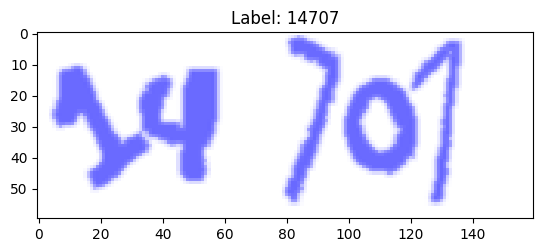

In [85]:
image, label = load_image_and_label(base_img_paths[0], label_paths[0], 1)
plt.imshow(image)
plt.title(f'Label: {label}')
plt.show()

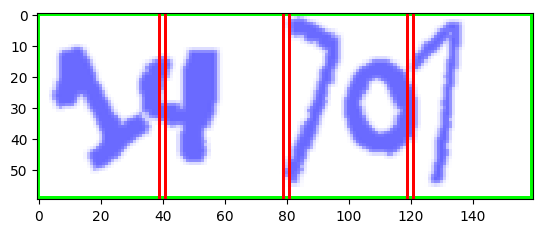

In [86]:
os.environ["TESSDATA_PREFIX"]  = "/opt/homebrew/Cellar/tesseract/5.4.1/share/tessdata"
# 转换为灰度图像
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)
bit_not = cv2.bitwise_not(thresh)
contours, hierarchy = cv2.findContours(bit_not, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(image, contours, -1, (0, 255, 0), 1)
rects = [cv2.boundingRect(cnt) for cnt in contours]
rects = sorted(rects, key=lambda x: x[2])
while len(rects) < 4:
    wide_rect = rects.pop()
    x, y, w, h = wide_rect
    first_half = (x, y, w//2, h)
    second_half = (x + w//2, y, w//2, h)
    rects.append(first_half)
    rects.append(second_half)
    rects.sort(key=lambda x: x[2])

for rect in rects:
    x, y, w, h = rect
    cv2.rectangle(image, (x-1, y-1), (x + w + 1, y + h + 1), (255, 0, 0), 1)
    
plt.imshow(image)

In [66]:
DEBUG = 1
# Load all images and labels
def load_all_images_and_labels(base_img_path, label_path):
    df = pd.read_csv(label_path)
    if DEBUG == 1:
        df = df[:100]
    images = []
    labels = []
    for idx in range(1, len(df)+1):
        if idx % 10 == 0:
            print(f'Now loaded {idx} images, total {len(df)} images')
        img, label = load_image_and_label(base_img_path, label_path, idx)
        images.append(img)
        labels.append(label)
    return images, labels

In [48]:
import torch
# Define our CNN model with pytorch
class CaptchaSolverCNN(torch.nn.Module):
    def __init__(self):
        super(CaptchaSolverCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, 3)
        self.conv2 = torch.nn.Conv2d(32, 64, 3)
        self.conv3 = torch.nn.Conv2d(64, 128, 3)
        self.fc1 = torch.nn.Linear(128*6*6, 1024)
        self.fc2 = torch.nn.Linear(1024, 256)
        self.fc3 = torch.nn.Linear(256, 36)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.dropout = torch.nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = self.pool(torch.nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 128*6*6)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [60]:
def train(level): # level is from 1 to 
    # Load images and labels
    images, labels = load_all_images_and_labels(base_img_paths[level-1], label_paths[level-1])
    
    # Define our CNN model
    model = CaptchaSolverCNN()
    
    # Define loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Train the model
    for epoch in range(10):
        print(len(images))
        for i in range(len(images)):
            img = images[i]
            label = labels[i]
            
            # Preprocess image
            img = cv2.resize(img, (32, 32))
            img = img / 255
            # img is BGR in opencv, convert to RGB
            img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
            # Preprocess label
            print(f"label is {label}, {ord('0')}")
            label = ord(label) - ord('a') if 'a' <= label <= 'z' else ord(label) - ord('0') + 26
            label = torch.tensor(label, dtype=torch.long).unsqueeze(0)
            
            # Forward pass
            outputs = model(img)
            loss = criterion(outputs, label)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if i % 100 == 0:
                print(f'Epoch {epoch}, Iteration {i}, Loss: {loss.item()}')
                
    # Save the model
    torch.save(model.state_dict(), f'../models/captcha_solver_level_{level}.pt')

for level in range(1, 6):
    train(level)

Now loaded 10 images, total 100 images
Now loaded 20 images, total 100 images
Now loaded 30 images, total 100 images
Now loaded 40 images, total 100 images
Now loaded 50 images, total 100 images
Now loaded 60 images, total 100 images
Now loaded 70 images, total 100 images
Now loaded 80 images, total 100 images
Now loaded 90 images, total 100 images
Now loaded 100 images, total 100 images
100
label is 14707, 48


UFuncTypeError: ufunc 'greater_equal' did not contain a loop with signature matching types (<class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.StrDType'>) -> None